In [1]:
from houseofreps import *
import numpy as np
import matplotlib.pyplot as plt
import csv 
import os
import pandas
from typing import List, Dict, Tuple


# Representation per citizen of each state

In [2]:
def save_fig(fname: str):
    if not os.path.isdir("figures"):
        os.makedirs('figures')
    s = os.path.join("figures/",fname)
    plt.savefig(s)

    print("Saved figure to: %s" % s)

In [25]:
def write_csv_residents_per_rep(fname: str, residents_per_rep: Dict[str, Dict[str, float]]):
    with open(fname, 'w') as csvfile: 

        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        
        # writing the fields
        header = ['year', 'state', 'residents per rep']
        csvwriter.writerow(header) 
            
        # writing the data rows 
        rows = []
        for year, d2 in residents_per_rep.items():
            for state, rpr in d2.items():
                rows.append([year, state, "%.8f" % rpr])

        csvwriter.writerows(rows)

In [26]:
house = HouseOfReps()

residents_per_rep = {}
for year in Year:
    residents_per_rep[year.value] = {}

    house.reset_pops_assigned_to_true(year, PopType.APPORTIONMENT)

    for st, state in house.states.items():
        if st != St.DISTRICT_OF_COLUMBIA:
            residents_per_rep[year.value][st.name] = 1e6 * state.pop_true[year].apportionment / state.no_reps_true[year].voting
            # print(st.name," ",residents_per_rep)
    
    fair = 1e6 * house.get_total_us_pop_true(year,PopType.APPORTIONMENT) / 435.0
    residents_per_rep[year.value]['fair'] = fair

# Write
write_csv_residents_per_rep("analyze_data/residents_per_rep.csv",residents_per_rep)

## Plot

Saved figure to: figures/no_residents_per_rep_2020.png


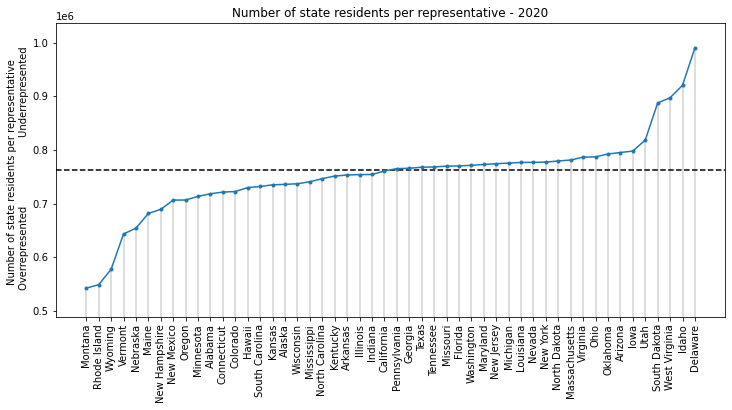

Saved figure to: figures/no_residents_per_rep_2010.png


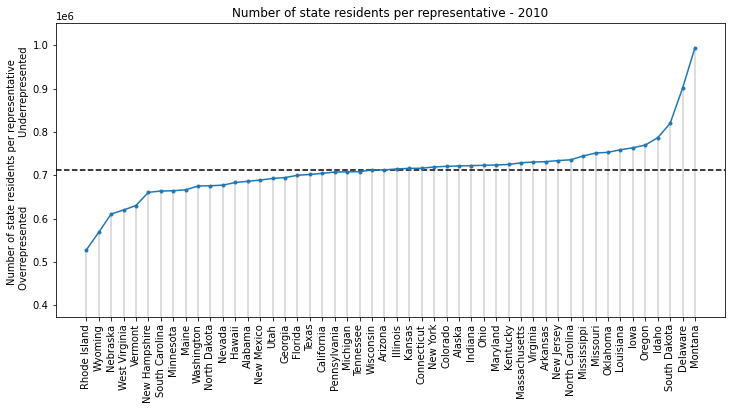

Saved figure to: figures/no_residents_per_rep_2000.png


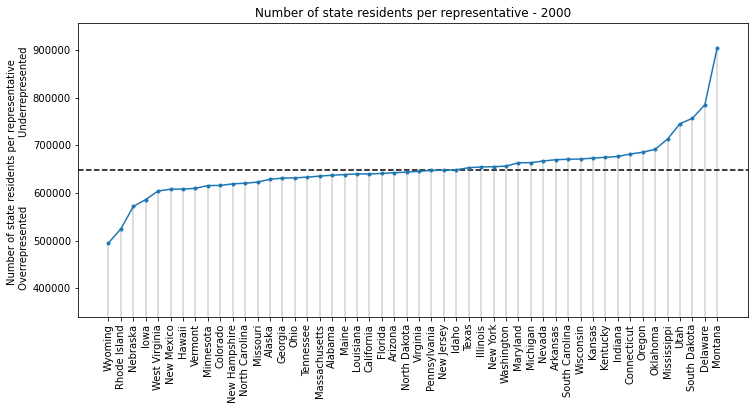

Saved figure to: figures/no_residents_per_rep_1990.png


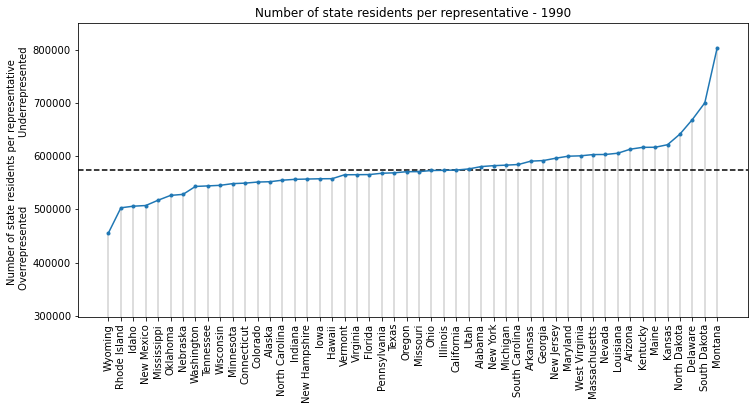

Saved figure to: figures/no_residents_per_rep_1980.png


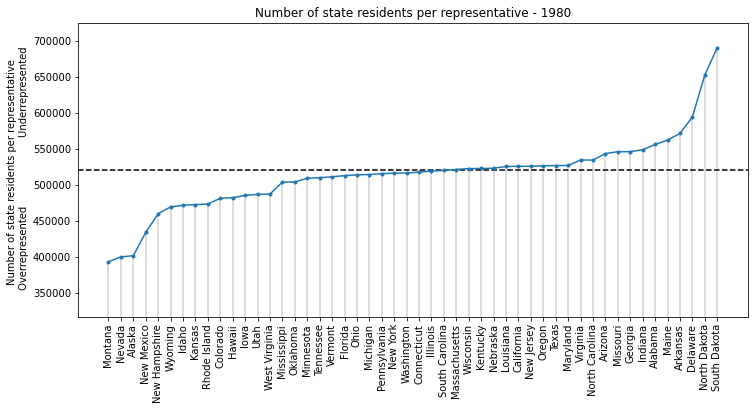

Saved figure to: figures/no_residents_per_rep_1970.png


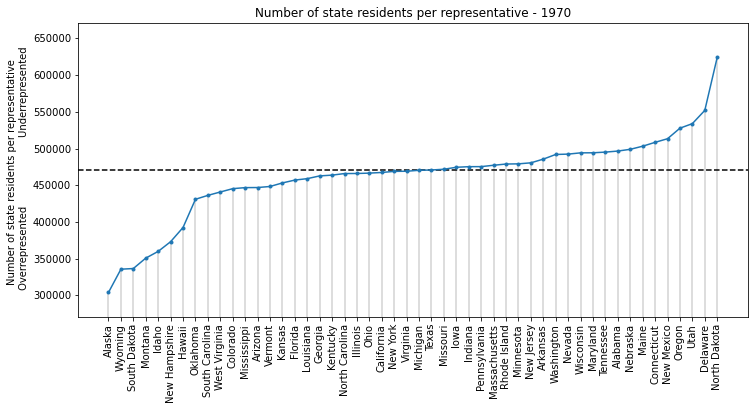

Saved figure to: figures/no_residents_per_rep_1960.png


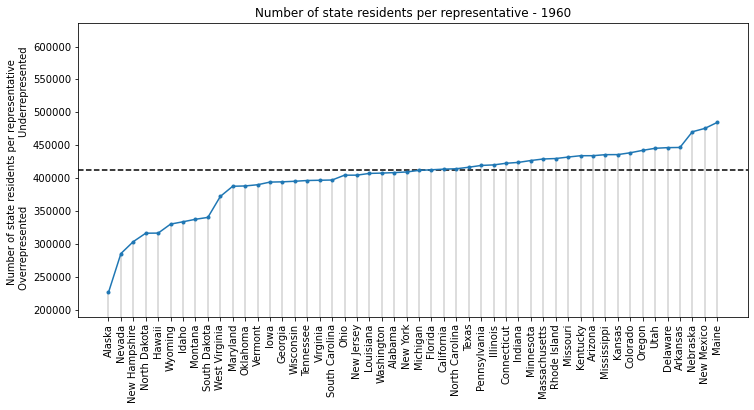

In [38]:
df = pd.read_csv('analyze_data/residents_per_rep.csv')

for year in Year:
    df_year = df[df['year'] == int(year.value)]
    fair = float(df_year[df_year['state'] == 'fair']['residents per rep'])
    df_year = df_year[df_year['state'] != 'fair']

    df_year = df_year.sort_values(by=['residents per rep'])

    xticks = list(df_year['state'])
    y = list(df_year['residents per rep'])
    x = np.arange(0,len(xticks))

    min_delta = fair - min(y)
    max_delta = max(y) - fair
    delta = 1.2*max(min_delta, max_delta)

    plt.figure(figsize=(12,6))
    plt.axhline(fair,linestyle='dashed',color='black')
    plt.xticks(x, xticks, rotation=90)
    plt.plot(x, y, '.-')
    plt.vlines(x, [0], y, color='lightgray')
    plt.ylabel("Number of state residents per representative \n Overrepresented                      Underrepresented")
    plt.ylim(fair-delta,fair+delta)
    plt.title('Number of state residents per representative - %s' % year.value)

    plt.subplots_adjust(bottom=0.2)
    save_fig('no_residents_per_rep_%s.png' % year.value)

    plt.show()

## Plot rankings as a bump chart in time

In [40]:
df = pd.read_csv('analyze_data/residents_per_rep.csv')

rankings = {}
for year in Year:
    df_year = df[df['year'] == int(year.value)]
    df_year = df_year[df_year['state'] != 'fair']

    df_year = df_year.sort_values(by=['residents per rep'])

    rankings[year] = list(df_year['state'])

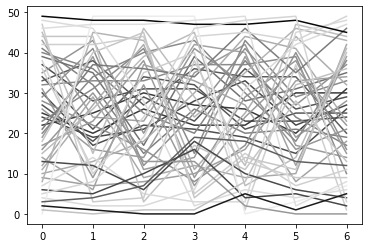

In [61]:
plt_data = {}
for st in [x for x in St if x != St.DISTRICT_OF_COLUMBIA]:
    x = np.arange(0,len(rankings))
    y = [ranks.index(st.name) for ranks in rankings.values()]

    # Color by the variance in the ranking to identify states that are consistently over/under represented
    mean = np.mean(y)
    std = np.std(y)

    plt_data[st] = (x,y,mean,std)

std_max = max([x[2] for x in plt_data.values()])
std_min = min([x[2] for x in plt_data.values()])

plt.figure()
for st, dat in plt_data.items():
    x, y, mean, std = dat
    col = 0.1 + 0.9 * (1 - pow(1 - (std-std_min) / (std_max - std_min),4))
    plt.plot(x, y, color=(col,col,col))

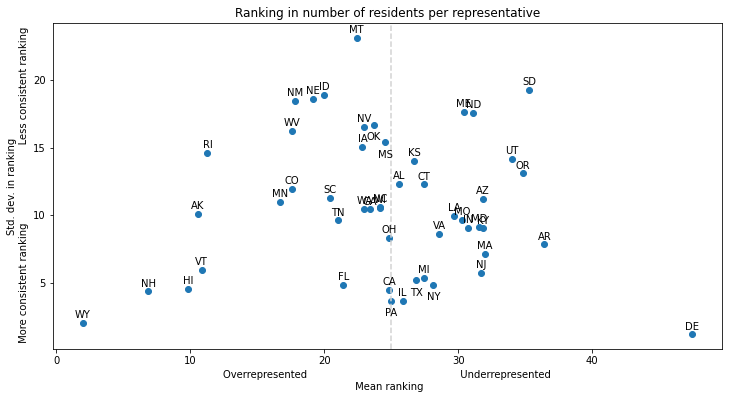

In [81]:
mean_dat = [x[2] for x in plt_data.values()]
std_dat = [x[3] for x in plt_data.values()]
labels = [x.value for x in plt_data.keys()]

plt.figure(figsize=(12,6))
plt.axvline(25,color='lightgray',linestyle='dashed')
plt.scatter(mean_dat, std_dat)
plt.xlabel('Overrepresented                                                 Underrepresented\n Mean ranking')
plt.ylabel('Std. dev. in ranking\n More consistent ranking                         Less consistent ranking')
plt.title('Ranking in number of residents per representative')

downs = ['TX','NY','PA','OK','MS']
for i, txt in enumerate(labels):
    if txt in downs:
        xytext=(0,-15)
    else:
        xytext=(0,5)
    plt.annotate(
        txt, 
        (mean_dat[i], std_dat[i]),
        textcoords="offset points", # how to position the text
        xytext=xytext, # distance from text to points (x,y)
        ha='center'
        ) # horizontal alignment can be left, right or center

In [ ]:
# Delaware is consistently underrepresented
# Wyoming in consistently overrepresented
# Montana has the largest fluctuations in the rankings
# Not political; on the overrepresented side, there is Wyoming (dominantly republican), but also New Hampshire, Hawaii, Vermont which are all dominantly democrat
# On the underrepresented side there is Delaware (democrat), but also Arkansas, South Dakota and Utah (republican)

# Calculate how number of reps changes when population is increased/decreased, for each state

In [3]:
def write_csv(fname: str, pops_shift_millions: List[float], no_reps_assigned: Dict[St,List[Tuple[float,int,int]]]):
    with open(fname, 'w') as csvfile: 

        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        
        # writing the fields
        header = ['population shift (millions)']
        for st in no_reps_assigned.keys():
            header.append(st.value + " population (millions)")
            header.append(st.value + " no reps (voting)")
            header.append(st.value + " no reps (nonvoting)")
        
        csvwriter.writerow(header) 
            
        # writing the data rows 
        rows = []
        for i in range(0,len(list(no_reps_assigned.values())[0])):
            row = ["%.8f" % pops_shift_millions[i]]
            for nra in no_reps_assigned.values():
                row.append("%.8f" % nra[i][0]) # population (millions)
                row.append(nra[i][1]) # no voting reps
                row.append(nra[i][2]) # no nonvoting reps
            rows.append(row)

        csvwriter.writerows(rows)

In [8]:
def calculate_no_reps_assigned(house: HouseOfReps, year: Year, pops_shift_millions: List[float]) -> Dict[St,List[Tuple[float,int,int]]]:
    no_reps_assigned = {}
    for st2 in St:
        no_reps_assigned[st2] = []

    for pop_shift_millions in pops_shift_millions:
        house.reset_pops_assigned_to_true(year, PopType.APPORTIONMENT)
        try:
            house.shift_pop_from_entire_us_to_state(
                st_to=st, 
                pop_add_millions=pop_shift_millions, 
                verbose=False
                )
        except:
            # Population of state would be negative
            print("Stopping early - removing: %f people is more than the number of people in the state" % pop_shift_millions)
            break

        house.assign_house_seats_priority()

        for st2 in St:
            pop = house.states[st2].pop_assigned
            n1 = house.states[st2].no_reps_assigned.voting
            n2 = house.states[st2].no_reps_assigned.nonvoting
            no_reps_assigned[st2].append((pop,n1,n2))
    
    return no_reps_assigned

In [9]:
house = HouseOfReps()

# Population to add to the state, detracted from the rest of the USA
pops_add_millions = list(0.005*np.arange(0,201))
pops_lost_millions = list(-0.005*np.arange(0,201))

for year in Year:

    # For exporting data
    dir_name_add = 'analyze_data/population_add_%s' % year.value
    dir_name_lose = 'analyze_data/population_lose_%s' % year.value
    if not os.path.isdir(dir_name_add):
        os.makedirs(dir_name_add)
    if not os.path.isdir(dir_name_lose):
        os.makedirs(dir_name_lose)
    
    for st in St:
        print("Calculating for year: %s state: %s" % (year.value, st.name))
        
        no_reps_assigned = calculate_no_reps_assigned(house, year, pops_add_millions)
        write_csv(os.path.join(dir_name_add, '%s.csv' % st.value), pops_add_millions, no_reps_assigned)

        no_reps_assigned = calculate_no_reps_assigned(house, year, pops_lost_millions)
        write_csv(os.path.join(dir_name_lose, '%s.csv' % st.value), pops_lost_millions, no_reps_assigned)

Calculating for year: 2020 state: California


# Min population shift to get an additional representative

In [79]:
def write_csv_rep(fname: str, header: List[str], min_pop_changes_for_next_rep):
    with open(fname, 'w') as csvfile: 

        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        
        # writing the fields        
        csvwriter.writerow(header) 
            
        # writing the data rows 
        rows = []
        for i in range(0,len(min_pop_changes_for_next_rep)):
            st, min_pop_change_for_next_rep, st_lost, pop_lost = min_pop_changes_for_next_rep[i]
            row = [
                st.name,
                "%.4f" % min_pop_change_for_next_rep,
                st_lost.name,
                "%.4f" % pop_lost
            ]
            rows.append(row)

        csvwriter.writerows(rows)

In [80]:
min_pop_changes_for_next_rep = []
for st in [x for x in St if x != St.DISTRICT_OF_COLUMBIA]:
    # Import data
    fname = 'analyze_data/population_added_2010/%s.csv' % st.value
    df = pandas.read_csv(fname)
    
    pop_shifts_millions = df['population shift (millions)'].to_numpy()
    no_reps_voting = df['%s no reps (voting)' % st.value].to_numpy()

    ichange = -1
    for i in range(1,len(no_reps_voting)):
        if no_reps_voting[i] != no_reps_voting[0]:
            # Found it
            ichange = i
            break

    if ichange != -1:
        min_pop_change_for_next_rep = pop_shifts_millions[ichange]
    else:
        min_pop_change_for_next_rep = 10000
    
    # Who lost the rep?
    st_lost = None
    for st_2 in St:
        if st_2 == st:
            continue
        no_reps_2 = df['%s no reps (voting)' % st_2.value].to_numpy()
        if no_reps_2[0] != no_reps_2[ichange]:
            # This is the one
            if st_lost != None:
                print("ERROR: 2 states lost a rep??? Something went wrong!")
                assert False
            st_lost = st_2
    
    # Population lost in this state
    pop_lost = None
    if st_lost != None:
        pop_lost = df["%s population (millions)" % st_lost.value][0] - df["%s population (millions)" % st_lost.value][ichange]

    min_pop_changes_for_next_rep.append((st,min_pop_change_for_next_rep, st_lost, pop_lost))

# Sort
min_pop_changes_for_next_rep.sort(key = lambda x: x[1])
for x in min_pop_changes_for_next_rep:
    print("%s: min pop change for next rep (millions): %.4f state that lost the rep: %s pop lost: %s" % (x[0], x[1], x[2], x[3]))

header = ['state', 'min. population change for next rep', 'state that lost the rep', 'population this other state lost']
write_csv_rep("analyze_data/one_more_rep.csv", header, min_pop_changes_for_next_rep)

St.MONTANA: min pop change for next rep (millions): 0.0100 state that lost the rep: St.MINNESOTA pop lost: 0.00017212000000021987
St.MISSOURI: min pop change for next rep (millions): 0.0150 state that lost the rep: St.MINNESOTA pop lost: 0.00026244000000019696
St.NORTH_CAROLINA: min pop change for next rep (millions): 0.0200 state that lost the rep: St.MINNESOTA pop lost: 0.00035407000000020616
St.OREGON: min pop change for next rep (millions): 0.0450 state that lost the rep: St.MINNESOTA pop lost: 0.0007817600000006308
St.LOUISIANA: min pop change for next rep (millions): 0.0500 state that lost the rep: St.MINNESOTA pop lost: 0.0008706300000005385
St.NEW_JERSEY: min pop change for next rep (millions): 0.0650 state that lost the rep: St.MINNESOTA pop lost: 0.0011478199999999106
St.NEW_YORK: min pop change for next rep (millions): 0.1050 state that lost the rep: St.MINNESOTA pop lost: 0.001921940000000788
St.DELAWARE: min pop change for next rep (millions): 0.1050 state that lost the re

# Min population shift to lose a representative

In [87]:
min_pop_changes_for_losing_rep = []
for st in St:
    # Import data
    fname = 'analyze_data/population_lost_2010/%s.csv' % st.value
    df = pandas.read_csv(fname)
    
    pop_shifts_millions = df['population shift (millions)'].to_numpy()
    no_reps_voting = df['%s no reps (voting)' % st.value].to_numpy()

    ichange = -1
    for i in range(1,len(no_reps_voting)):
        if no_reps_voting[i] != no_reps_voting[0]:
            # Found it
            ichange = i
            break

    if ichange == -1:
        continue
    min_pop_change_for_losing_rep = pop_shifts_millions[ichange]

    # Who gained the rep?
    st_gained = None
    for st_2 in St:
        if st_2 == st:
            continue
        no_reps_2 = df['%s no reps (voting)' % st_2.value].to_numpy()
        if no_reps_2[0] != no_reps_2[ichange]:
            # This is the one
            if st_gained != None:
                print("ERROR: 2 states gaining a rep??? Something went wrong!")
                assert False
            st_gained = st_2
    
    # Population gained in this state
    pop_gained = None
    if st_gained != None:
        pop_gained = df["%s population (millions)" % st_gained.value][ichange] - df["%s population (millions)" % st_gained.value][0]

    min_pop_changes_for_losing_rep.append((st, min_pop_change_for_losing_rep, st_gained, pop_gained))

# Sort
min_pop_changes_for_losing_rep.sort(key = lambda x: -x[1])
for x in min_pop_changes_for_losing_rep:
    print("%s: min pop change for losing rep (millions): %.4f state that gained the rep: %s pop gained: %s" % (x[0], x[1], x[2], x[3]))

header = ['state', 'min. population change for losing rep', 'state that gained the rep', 'population this other state gained']
write_csv_rep("analyze_data/one_less_rep.csv", header, min_pop_changes_for_losing_rep)

St.MINNESOTA: min pop change for losing rep (millions): -0.0100 state that gained the rep: St.NORTH_CAROLINA pop gained: 0.00031418000000016377
St.WASHINGTON: min pop change for losing rep (millions): -0.0300 state that gained the rep: St.NORTH_CAROLINA pop gained: 0.0009470100000008586
St.SOUTH_CAROLINA: min pop change for losing rep (millions): -0.0500 state that gained the rep: St.NORTH_CAROLINA pop gained: 0.001567450000001358
St.RHODE_ISLAND: min pop change for losing rep (millions): -0.0550 state that gained the rep: St.NORTH_CAROLINA pop gained: 0.0017041400000010754
St.TEXAS: min pop change for losing rep (millions): -0.0950 state that gained the rep: St.NORTH_CAROLINA pop gained: 0.0031940100000014127
St.NEBRASKA: min pop change for losing rep (millions): -0.0950 state that gained the rep: St.NORTH_CAROLINA pop gained: 0.0029509300000007954
St.CALIFORNIA: min pop change for losing rep (millions): -0.1050 state that gained the rep: St.NORTH_CAROLINA pop gained: 0.00368667000000

## Plot one more/less rep

In [8]:
df_less = pd.read_csv('analyze_data/one_less_rep.csv')
df_more = pd.read_csv('analyze_data/one_more_rep.csv')

Saved figure to: figures/one_more_less_rep.png


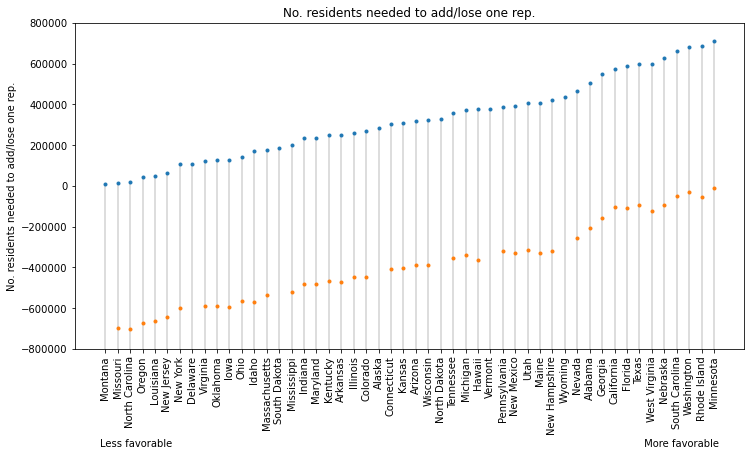

In [11]:
xticks_more = df_more['state'].to_numpy()
y_more = 1e6 * df_more['min. population change for next rep'].to_numpy()
x_more = np.arange(0,len(xticks_more))

map_st_to_idx = {}
for i in range(0,len(xticks_more)):
    map_st_to_idx[xticks_more[i]] = x_more[i]

xticks_less = df_less['state'].to_numpy()
y_less = 1e6 * df_less['min. population change for losing rep'].to_numpy()
x_less = [ map_st_to_idx[xtick] for xtick in xticks_less ]

# plt.figure()
# plt.plot(x_less,y_less,'.')
# plt.xticks(x, xticxs, rotation=90)

plt.figure(figsize=(12,6))
plt.xticks(x_more, xticks_more, rotation=90)
plt.plot(x_more,y_more,'.')
plt.vlines(x_more, [-800000], y_more, color='lightgray')
plt.plot(x_less,y_less,'.')
plt.ylim(-800000,800000)
plt.ylabel("No. residents needed to add/lose one rep.")
plt.xlabel("Less favorable                                                                                                                                                       More favorable")
plt.title("No. residents needed to add/lose one rep.")

save_fig('one_more_less_rep.png')
plt.show()

In [12]:
house = HouseOfReps()
year = Year.YR2010
house.reset_pops_assigned_to_true(year, PopType.APPORTIONMENT)

residents_per_rep = {}
for st, state in house.states.items():
    if st != St.DISTRICT_OF_COLUMBIA:
        residents_per_rep[st] = 1e6 * state.pop_true[year].apportionment / state.no_reps_true[year].voting
        # print(st.name," ",residents_per_rep)

residents_per_rep = dict(sorted(residents_per_rep.items(), key = lambda x: x[1]))
fair = 1e6 * house.get_total_us_pop_true(year,PopType.APPORTIONMENT) / 435.0

In [13]:
plt_data = {}
for idx, row in df_more.iterrows():
    state = row['state']
    st = St.fromName(state)
    dpop = 1e6*row['min. population change for next rep']
    cpr = residents_per_rep[st]
    plt_data[st] = [dpop, cpr]

Saved figure to: figures/favorable2d.png


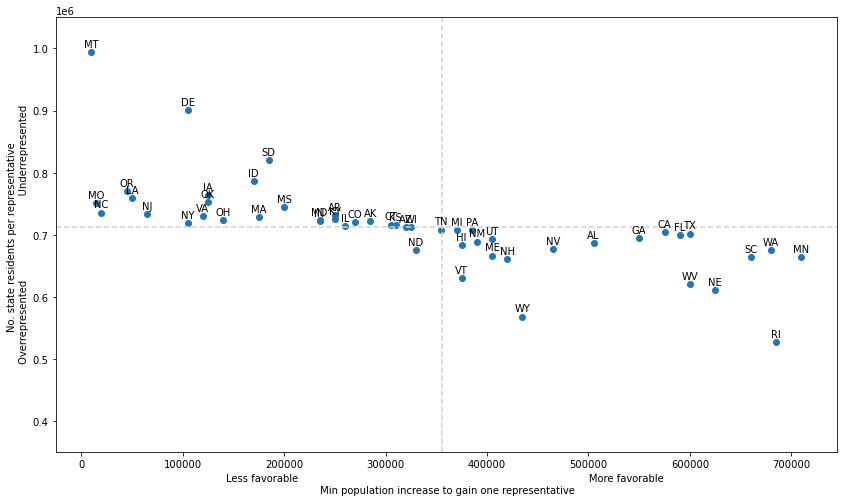

In [15]:
x = [p[0] for p in plt_data.values()]
y = [p[1] for p in plt_data.values()]
labels = [x.value for x in list(plt_data.keys())]

plt.figure(figsize=(14,8))
plt.scatter(x,y)
plt.ylabel("No. state residents per representative \n Overrepresented                           Underrepresented")

plt.axhline(fair,color='lightgray',linestyle='dashed')
plt.ylim(0.35e6,1.05e6)
plt.axvline(0.5*fair,color='lightgray',linestyle='dashed')
plt.xlabel("Less favorable                                                                                             More favorable \n Min population increase needed to gain one representative")

for i, txt in enumerate(labels):
    plt.annotate(
        txt, 
        (x[i], y[i]),
        textcoords="offset points", # how to position the text
        xytext=(0,5), # distance from text to points (x,y)
        ha='center'
        ) # horizontal alignment can be left, right or center

save_fig('favorable2d.png')
plt.show()